In [1]:
import os 
import timm
import torch
import torch
import torch.nn as nn
import requests
import timm
import math
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from lightly.data.dataset import LightlyDataset

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2]:
from multissl.models import MSRGBConvNeXtInstanceSegmentationModule
from multissl.plotting.rgb_batch import rgb_visualize_batch
from multissl.data.instance_segmentation_dataset import COCOInstanceSegmentationDataset, get_instance_transforms, augmented_duplicates_collate_fn

# Segmentation Head Loading

In [3]:

args = {"checkpoint_path":"../checkpoints_convnext_tiny/last.ckpt",
    "num_classes": 2,
    "class_names": ["Background", "Solarpanel"],
    "freeze_backbone": True,
    "batch_size": 4,
    "img_size": 448,

       }
# pretrained tiny has hierarchical fusion: at every layer MS +RGB is fused with attention

pl_model =  MSRGBConvNeXtInstanceSegmentationModule(
        num_classes=args["num_classes"],  # Binary segmentation (background, foreground)
        rgb_in_channels=3,
        ms_in_channels=5,  # Adjust based on your MS data
        model_size='tiny',  # Can be 'tiny', 'small', 'base', 'large'
        fusion_strategy='hierarchical',  # 'early', 'late', 'hierarchical', 'progressive'
        fusion_type='attention',  # 'concat', 'add', 'attention'
        learning_rate=1e-4,
        weight_decay=1e-4,
        pretrained_backbone=args["checkpoint_path"],  # Path to pretrained weights if available
        freeze_backbone = True
    )

Loading checkpoint from ../checkpoints_convnext_tiny/last.ckpt
Unexpected keys: ['projection_head.layers.0.weight', 'projection_head.layers.1.weight', 'projection_head.layers.1.bias', 'projection_head.layers.1.running_mean', 'projection_head.layers.1.running_var', 'projection_head.layers.1.num_batches_tracked', 'projection_head.layers.3.weight', 'projection_head.layers.4.weight', 'projection_head.layers.4.bias', 'projection_head.layers.4.running_mean', 'projection_head.layers.4.running_var', 'projection_head.layers.4.num_batches_tracked', 'projection_head.layers.6.weight', 'projection_head.layers.7.running_mean', 'projection_head.layers.7.running_var', 'projection_head.layers.7.num_batches_tracked', 'prediction_head.layers.0.weight', 'prediction_head.layers.1.weight', 'prediction_head.layers.1.bias', 'prediction_head.layers.1.running_mean', 'prediction_head.layers.1.running_var', 'prediction_head.layers.1.num_batches_tracked', 'prediction_head.layers.3.weight', 'prediction_head.layers.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


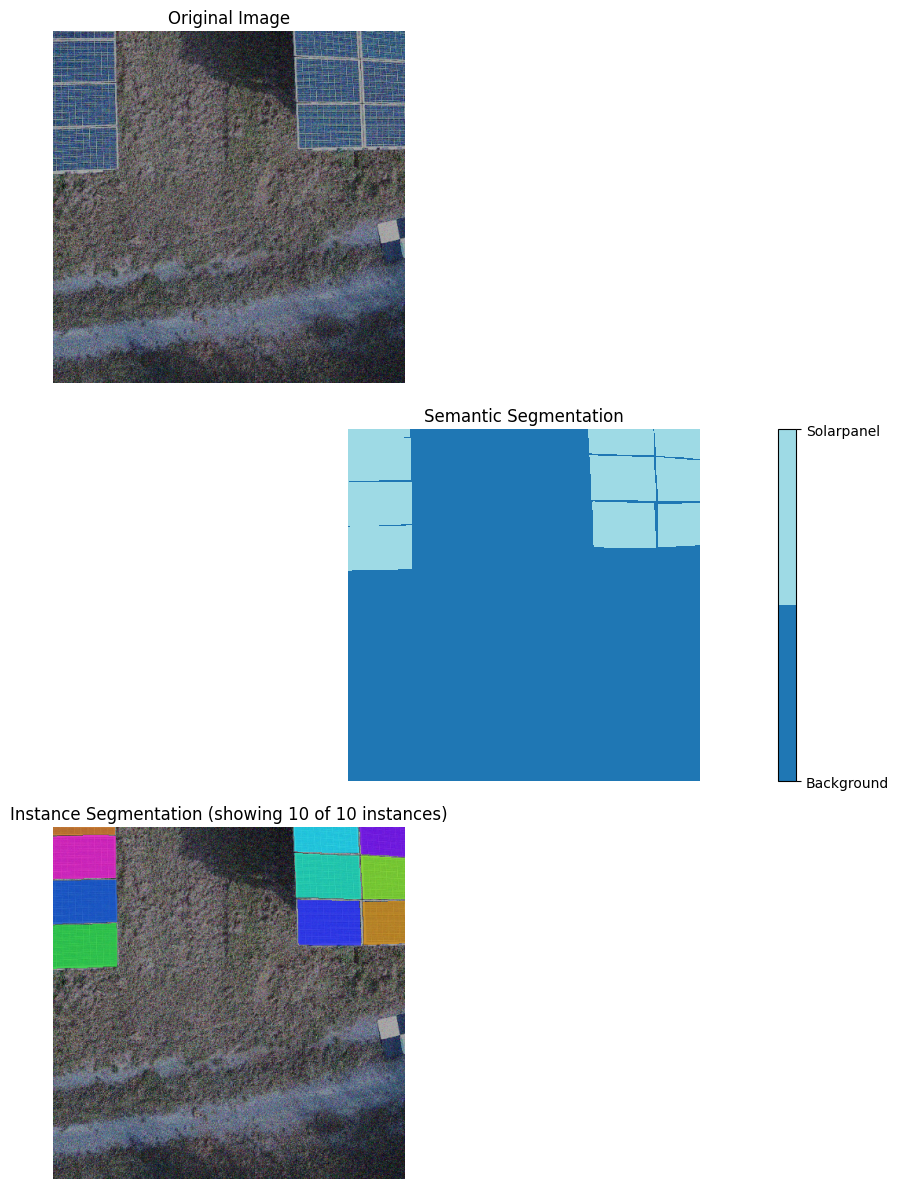

In [5]:
image_path = "../dataset/solarcoco/imgs"
mask_path = "../dataset/solarcoco/annotations/frame_000003.JSON"
instance_path = "../dataset/solarcoco/instance"


# Create dataset
dataset = COCOInstanceSegmentationDataset(
   coco_json_path = mask_path,
    img_dir = image_path,
    instance_dir = instance_path,
    transform=get_instance_transforms(img_size=args["img_size"], augment=True)

)


batch = next(iter(dataset))

# Visualize just the one-hot instances
fig = dataset.visualize_instance_segmentation(
    batch = batch,
    class_ids=[0,1],
    class_names= args["class_names"]
)

plt.show()



In [14]:
def instance_segmentation_collate_fn(batch_size=16):
    """
    Simple collate function specifically designed to handle variable-sized
    instance masks and boxes in instance segmentation data
    
    Args:
        batch_size: Target batch size
        
    Returns:
        collate_fn: Function that handles instance segmentation data
    """
    def collate_fn(batch):
        """
        Collate instance segmentation samples, properly handling variable-sized tensors
        
        Args:
            batch: List of samples to collate
            
        Returns:
            Batch dictionary with properly batched tensors
        """
        # Make sure we have at least one sample
        if not batch or len(batch) == 0:
            raise ValueError("Batch must contain at least one sample")
        
        # Duplicate the single sample if needed
        if len(batch) == 1 and batch_size > 1:
            batch = [batch[0]] * batch_size
        
        # Create the batch dictionary
        batch_dict = {}
        
        # Get all keys from the first sample
        keys = batch[0].keys()
        
        # Process each key
        for key in keys:
            # Skip None values
            if batch[0][key] is None:
                batch_dict[key] = None
                continue
                
            # Check if the value is a tensor
            if isinstance(batch[0][key], torch.Tensor):
                # Special handling for known variable-sized tensors
                if key in ['instance_masks', 'boxes', 'instance_classes']:
                    # Store as list of tensors
                    batch_dict[key] = [sample[key] for sample in batch]
                else:
                    # Try to stack other tensors, fall back to list if sizes differ
                    try:
                        batch_dict[key] = torch.stack([sample[key] for sample in batch], dim=0)
                    except RuntimeError as e:
                        if "stack expects each tensor to be equal size" in str(e):
                            # Store as list if sizes differ
                            batch_dict[key] = [sample[key] for sample in batch]
                        else:
                            # Re-raise other errors
                            raise e
            elif isinstance(batch[0][key], (int, float, str)):
                # Store scalar values as list
                batch_dict[key] = [sample[key] for sample in batch]
            else:
                # Other types (lists, dicts, etc.) stored as list
                batch_dict[key] = [sample[key] for sample in batch]
        
        return batch_dict
    
    return collate_fn


In [17]:
collate_fn = instance_segmentation_collate_fn(args["batch_size"])
# Create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=args["batch_size"], 
    num_workers=0,
    # Use 0 for single image to avoid overhead,
    collate_fn = collate_fn


)


In [18]:
# Create progress bar callback
from pytorch_lightning.callbacks import RichProgressBar
class LossProgressBar(RichProgressBar):
    def __init__(self):
        super().__init__()
        self.losses = []
        
    def on_train_epoch_end(self, trainer, pl_module):
        super().on_train_epoch_end(trainer, pl_module)
        loss = float(trainer.callback_metrics.get('train_loss', 0))
        self.losses.append(loss)
        
progress_bar = LossProgressBar()

# Create model checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='train_loss',
    filename='pasiphae-upernet-{epoch:02d}-{train_loss:.4f}',
    save_top_k=1,
    mode='min'
)

# Early stopping callback
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='train_loss',
    patience=10,
    mode='min'
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=200,
    devices=1,
    callbacks=[progress_bar, checkpoint_callback, early_stop_callback],
    logger=True,
    log_every_n_steps=1,
    accelerator = "cuda"
)

# Train model
print("Starting training...")
trainer.fit(pl_model, dataloader)

print("Training complete!")




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                   ┃ Type                              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                  │ MSRGBConvNeXtInstanceSegmentation │  117 M │ train │
│ 1 │ semantic_criterion     │ CrossEntropyLoss                  │      0 │ train │
│ 2 │ center_criterion       │ BCELoss                           │      0 │ train │
│ 3 │ box_criterion          │ SmoothL1Loss                      │      0 │ train │
│ 4 │ instance_cls_criterion │ CrossEntropyLoss                  │      0 │ train │
│ 5 │ mask_criterion         │ BCEWithLogitsLoss                 │      0 │ train │
└───┴────────────────────────┴───────────────────────────────────┴────────┴───────┘

Trainable params: 117 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 117 M                                                                                                
Total estimated model params size (MB): 470                                                                        
Modules in train mode: 547                                                                                         
Modules in eval mode: 0

Output()

AttributeError: 'list' object has no attribute 'shape'

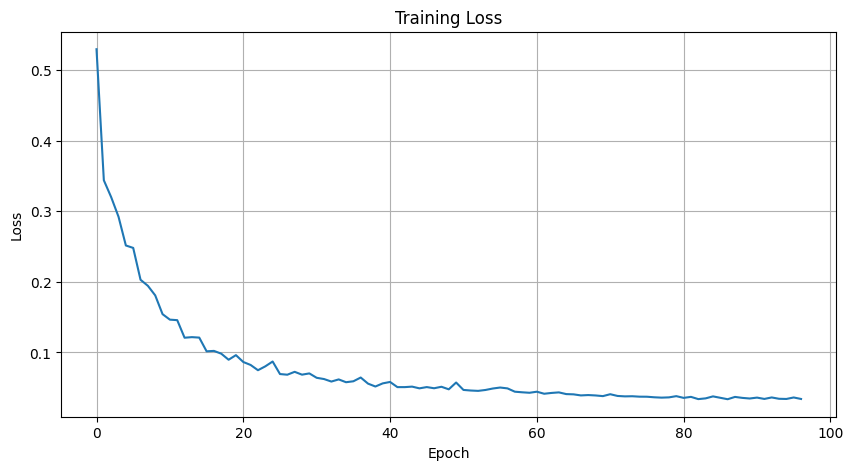

In [7]:
# Plot loss curve
losses = progress_bar.losses
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [11]:
# Save model
model = pl_model.model




In [12]:
# Apply to dataset:
# Create train/val/test datasets
rgb_transform = transforms.Compose([
    transforms.Resize((cfg["img_size"],cfg["img_size"] ), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])


solar_folder = "../dataset/pvhawk" 

non_labeled = LightlyDataset(input_dir = "../dataset/pvhawk",transform=rgb_transform)
non_labeled = torch.utils.data.DataLoader(non_labeled)

In [13]:
# Process all images
num_samples=10
device='cuda'
model.to(device)
all_results = []

model.eval()

for img, idx, img_name in tqdm(iter(non_labeled)):
    img = img.to(device)
    
    with torch.no_grad():
        output = model(rgb  = img)
        
    # Get predicted segmentation mask
    pred_mask = torch.argmax(output, dim=1).cpu().numpy()
    
    # Convert tensor back to PIL image for visualization
    orig_img = img.cpu().squeeze(0)
    # Denormalize
    orig_img = torch.clamp(orig_img, 0, 1)
    
    # Store results
    all_results.append({
        'image': orig_img.permute(1, 2, 0).numpy(),
        'mask': pred_mask[0],
        'filename': img_name[0]
    })
    

# Sample random images
if len(all_results) > num_samples:
    random_samples = random.sample(all_results, num_samples)
else:
    random_samples = all_results
    



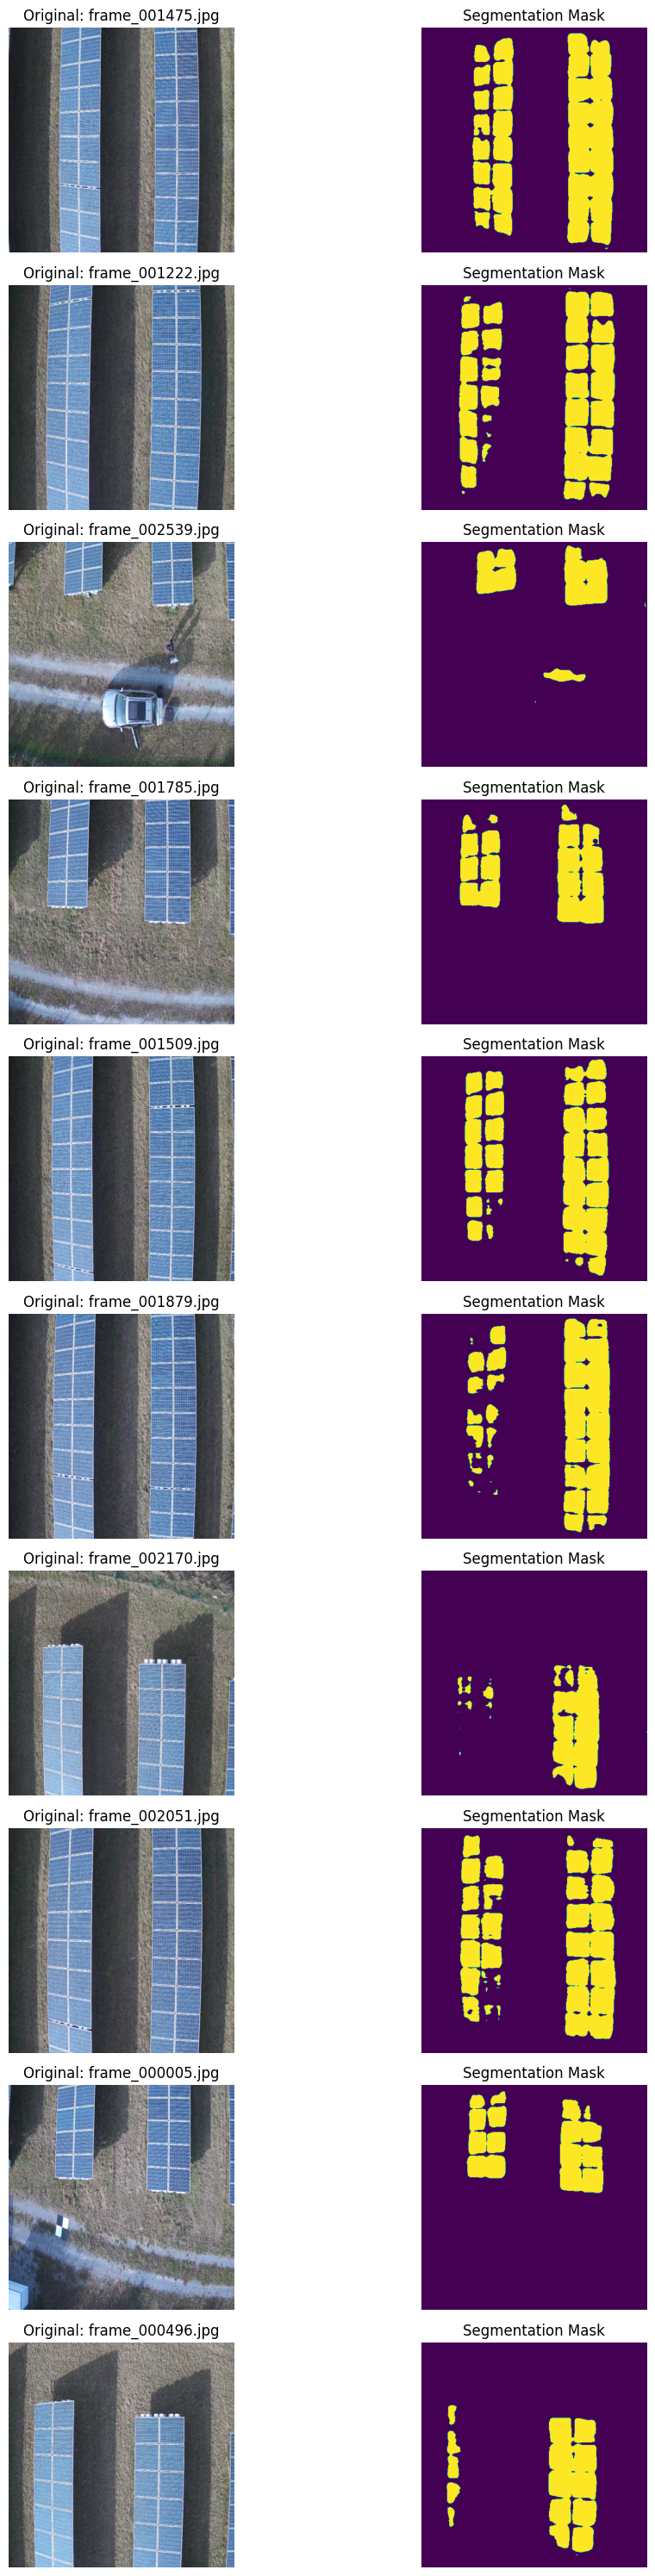

In [14]:
# Visualize the results
def visualize_segmentation(samples):
    fig, axes = plt.subplots(len(samples), 2, figsize=(12, 3*len(samples)))
    
    # If only one sample, wrap axes in a list
    if len(samples) == 1:
        axes = [axes]
    
    for i, sample in enumerate(samples):
        # Original image
        axes[i][0].imshow(sample['image'])
        axes[i][0].set_title(f"Original: {sample['filename']}")
        axes[i][0].axis('off')
        
        # Segmentation mask - using a colormap to make it more visible
        axes[i][1].imshow(sample['mask'], cmap='viridis')
        axes[i][1].set_title(f"Segmentation Mask")
        axes[i][1].axis('off')
    
    plt.tight_layout()
    plt.savefig('segmentation_results.png', dpi=300, bbox_inches='tight')
    plt.show()


visualize_segmentation(random_samples)

In [ ]:


output_path = "model_trained_on_single_image.pth"
torch.save(model.state_dict(), output_path)
print(f"Model saved to {output_path}")
